At the end of this notebook, we will have submitted to the ["Paddy Doctor: Paddy Disease Classification" competition on Kaggle](https://www.kaggle.com/competitions/paddy-disease-classification/overview)!

Let us begin by downloading the data.

In [1]:
%%bash

exec bash
rm -rf data
mkdir data
apt install unzip

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-21ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [2]:
!cd data && kaggle competitions download -c paddy-disease-classification && unzip -q paddy-disease-classification.zip

100%|█████████████████████████████████████▉| 1.02G/1.02G [00:47<00:00, 22.8MB/s]
100%|██████████████████████████████████████| 1.02G/1.02G [00:48<00:00, 22.8MB/s]


We have now downloaded and extracted the data to the `data` directory.

In [3]:
ls data

paddy-disease-classification.zip  test_images/  train_images/
sample_submission.csv             train.csv


In [4]:
ls data/train_images

bacterial_leaf_blight/     blast/       downy_mildew/  tungro/
bacterial_leaf_streak/     brown_spot/  hispa/
bacterial_panicle_blight/  dead_heart/  normal/


In [5]:
ls data/test_images | head

200001.jpg
200002.jpg
200003.jpg
200004.jpg
200005.jpg
200006.jpg
200007.jpg
200008.jpg
200009.jpg
200010.jpg
ls: write error: Broken pipe


Seems that the train data is organized by directories, with the name of the directory being the label.

Test images just live in `data/test_images`

Let us see what is the format of the sample submission file to have a full picture.

In [6]:
import pandas as pd

sample_sub = pd.read_csv('data/sample_submission.csv')
sample_sub.head()

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN


Mhmm. Guessing the labels for the submission are the names of the directories.

Ok, let's start training!

In [7]:
from fastai.vision.all import *

I am going through the `01_intro.ipynb` notebook and it seems the files in the example there are organizedin a different way than the files here 🤔

Well, but I have the handy `doc` function! I bet it can give me a suggestion on how to approach this!

I see that this `ImageDataLoaders` is used... I run `doc` on it and click `Show in docs` to read a bit more about this in my browser.

In [8]:
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

Well, the `from_path_re` class method seems interesting. Maybe I can get it to work.

In [9]:
fns = get_image_files('data/train_images/')
fns # looks about right!

(#10407) [Path('data/train_images/bacterial_panicle_blight/109162.jpg'),Path('data/train_images/bacterial_panicle_blight/109183.jpg'),Path('data/train_images/bacterial_panicle_blight/101765.jpg'),Path('data/train_images/bacterial_panicle_blight/101592.jpg'),Path('data/train_images/bacterial_panicle_blight/104770.jpg'),Path('data/train_images/bacterial_panicle_blight/110190.jpg'),Path('data/train_images/bacterial_panicle_blight/106643.jpg'),Path('data/train_images/bacterial_panicle_blight/104269.jpg'),Path('data/train_images/bacterial_panicle_blight/108023.jpg'),Path('data/train_images/bacterial_panicle_blight/107676.jpg')...]

Now let me experiment with just a single path and a regex pattern.

In [10]:
import re

In [11]:
str(fns[0])

'data/train_images/bacterial_panicle_blight/109162.jpg'

In [12]:
pat = r'/([^/]*)/\d+.jpg$'
re.search(pat, str(fns[0])).group(1)

'bacterial_panicle_blight'

Well, this seems to work. Only way to find out is to try!

And don't worry about the regex. I copied it from the docs 😄 I don't mind writing regexes, expecially with useful [tools around](https://pythex.org/) but I always, ALWAYS have to google the API. Is it `search` or `match`? How do the groups work? Oh dear...

Anyhow

In [13]:
dls = ImageDataLoaders.from_path_re('data', fns, pat, item_tfms=Resize(224))

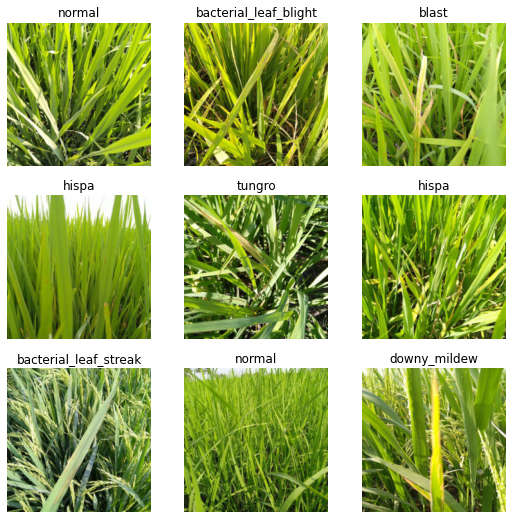

In [14]:
dls.train.show_batch()

Looks like it worked! 🥳

In [15]:
len(dls.train), len(dls.valid)

(130, 33)

In [16]:
dls.bs

64

In [17]:
dls.valid.bs

64

I am just clicking around, learning about the objects I got returned! Marvelous!

Let's train.

In [18]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.923554,1.044058,0.326766,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.763062,0.406154,0.132148,00:39


Well, that seems like a surprisingly good performance given how challenging the task seems 🤔

Let's see how we can obtain predictions from our model.

In [19]:
preds = learn.get_preds()

In [20]:
preds

(TensorBase([[1.8121e-05, 1.5539e-04, 9.2257e-06,  ..., 2.1801e-03, 9.9759e-01,
          4.3479e-06],
         [8.1836e-04, 1.0580e-03, 4.2039e-02,  ..., 6.5500e-03, 1.3760e-02,
          3.2911e-05],
         [1.0245e-03, 1.1458e-03, 8.7156e-05,  ..., 5.4241e-05, 3.6794e-07,
          1.0973e-01],
         ...,
         [2.9592e-03, 2.0527e-03, 8.9294e-01,  ..., 7.4734e-04, 6.8272e-04,
          1.4521e-04],
         [4.5424e-05, 2.3375e-06, 7.2678e-04,  ..., 8.4647e-05, 3.9246e-05,
          4.9339e-06],
         [4.6551e-04, 4.2779e-05, 1.4800e-05,  ..., 4.4493e-05, 2.2903e-06,
          6.1480e-03]]),
 TensorCategory([8, 5, 3,  ..., 2, 5, 4]))

In [21]:
preds[0][0].sum(), preds[0][0].max()

(TensorBase(1.), TensorBase(0.9976))

Looks like preds maybe holds class probabilities and label idxs? But where do I get the labels from?!

In [22]:
learn.dls.c

10

Mhmm, that's not it.

In [23]:
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

In [24]:
learn.dls.train_ds.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

After a bit of searching, I found where the category names are stored!

Now we need to predict on our test items!

In [25]:
test_dl = learn.dls.test_dl(get_image_files('data/test_images'))

In [26]:
test_preds = learn.get_preds(dl=test_dl)

In [27]:
sample_sub

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [28]:
get_image_files('data/test_images')

(#3469) [Path('data/test_images/200770.jpg'),Path('data/test_images/203307.jpg'),Path('data/test_images/203265.jpg'),Path('data/test_images/201796.jpg'),Path('data/test_images/202973.jpg'),Path('data/test_images/201780.jpg'),Path('data/test_images/201052.jpg'),Path('data/test_images/201179.jpg'),Path('data/test_images/201783.jpg'),Path('data/test_images/200080.jpg')...]

In [29]:
predicted_classes = [learn.dls.train_ds.vocab[i] for i in test_preds[0].argmax(1)]

In [30]:
predicted_classes[:10]

['bacterial_leaf_streak',
 'blast',
 'dead_heart',
 'bacterial_leaf_blight',
 'downy_mildew',
 'normal',
 'brown_spot',
 'tungro',
 'normal',
 'dead_heart']

And the last thing we need to output predictions are file names.

In [31]:
fns = [p.name for p in get_image_files('data/test_images')]

In [32]:
sub = pd.DataFrame(data={'image_id': fns, 'label': predicted_classes})

In [33]:
mkdir data/submissions

In [39]:
sub.to_csv('data/submissions/first_submissions.csv.gz', index=False)

In [40]:
!kaggle competitions submit -c paddy-disease-classification -f data/submissions/first_submissions.csv.gz -m "0.132148"

100%|██████████████████████████████████████| 11.6k/11.6k [00:00<00:00, 26.7kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification